In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff
from plotting_support import explode_volume

# SETUP - MODEL & REC GEOM

In [19]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 1, 1, 1
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 500 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [20]:
# Define Receiver grid as lines in X and Z
nr_z = 10
nr_x = 10
nr_y = 10
rec_string = '%i-by-%i-by-%i'%(nr_x,nr_y,nr_z)
rec_buffer = 5

# RECEIVER GRID - ONLY ON CUBE SURFACES
grid_z_locs = np.linspace(rec_buffer*dz, (nz-rec_buffer)*dz, nr_z)
grid_x_locs = np.linspace(rec_buffer*dx, (nx-rec_buffer)*dx, nr_x)
grid_y_locs = np.linspace(rec_buffer*dy, (ny-rec_buffer)*dy, nr_y)

F0_rx, F0_ry, F0_rz = np.meshgrid(0,           grid_y_locs, grid_z_locs)      # X face 0 
F1_rx, F1_ry, F1_rz = np.meshgrid(nx*dx,       grid_y_locs, grid_z_locs)      # X face 1 
F2_rx, F2_ry, F2_rz = np.meshgrid(grid_x_locs, 0,           grid_z_locs)      # Y face 0 
F3_rx, F3_ry, F3_rz = np.meshgrid(grid_x_locs, ny*dy,       grid_z_locs)      # Y face 1  
F4_rx, F4_ry, F4_rz = np.meshgrid(grid_x_locs, grid_y_locs, 0)   # Z face 0 
F5_rx, F5_ry, F5_rz = np.meshgrid(grid_x_locs, grid_y_locs, nz*dz)  # Z face 1 

grid_rx = np.vstack([rx.flatten() for rx in [F0_rx,F1_rx,F2_rx,F3_rx,F4_rx,F5_rx,]])
grid_ry = np.vstack([ry.flatten() for ry in [F0_ry,F1_ry,F2_ry,F3_ry,F4_ry,F5_ry,]])
grid_rz = np.vstack([rz.flatten() for rz in [F0_rz,F1_rz,F2_rz,F3_rz,F4_rz,F5_rz,]])
                     
gridded_recs = np.vstack((grid_rx.flatten(), grid_ry.flatten(), grid_rz.flatten()))
nr = gridded_recs.shape[1]

print (nr, gridded_recs.shape)

600 (3, 600)


# FAULT SOURCE - Image multiple and then stack

In [21]:
x_len = 5

xmicro = np.arange(nx//2,nx//2+x_len)
ymicro = ny//4 * np.ones_like(xmicro)
zmicro = nz//2 * np.ones_like(xmicro)
ampmicro = np.ones_like(xmicro)


ns = len(zmicro)
microseismic = np.zeros((ns, nx, ny, nz))
event_dictionary = []
for ev in range(ns):
    microseismic[ev, xmicro[ev], ymicro[ev], zmicro[ev]] = ampmicro[ev]
    event_dictionary.append({'event':ev,
                             'sx':xmicro[ev],
                             'sy':ymicro[ev],
                             'sz':zmicro[ev],
                             'amp':ampmicro[ev],
                            })
microseismic_line = np.sum(microseismic, axis=0)

In [22]:
microseismic.shape

(5, 50, 50, 50)

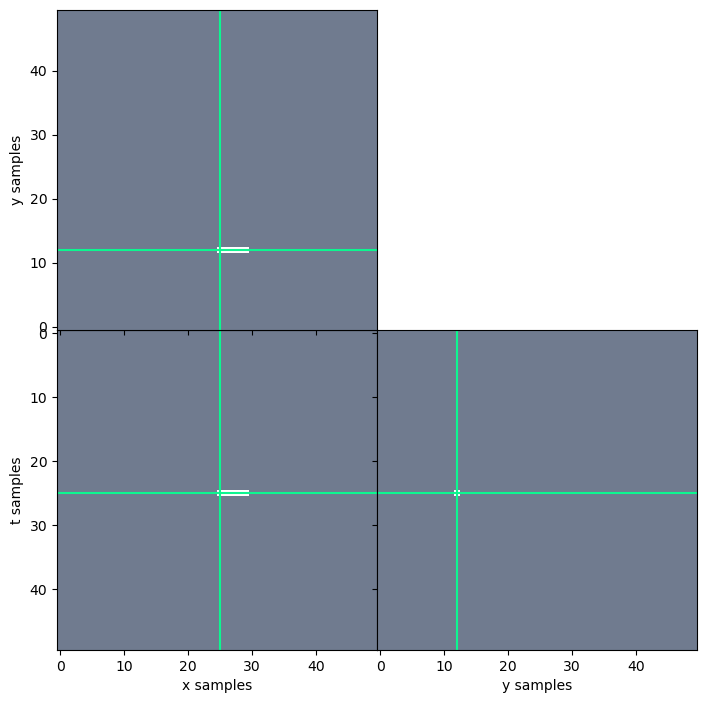

In [23]:
fig,axs = explode_volume(microseismic_line.transpose(2,0,1),  p=99.9999999,
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])

# MAKE DATA

In [24]:
nt = 251
dt = 0.001
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=35)

In [25]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=gridded_recs[:, :1], 
               recs=gridded_recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=45804.985029480194 - u^H(Op^Hv)=45804.98502948025


Text(0.5, 1.0, 'Seismic Recording')

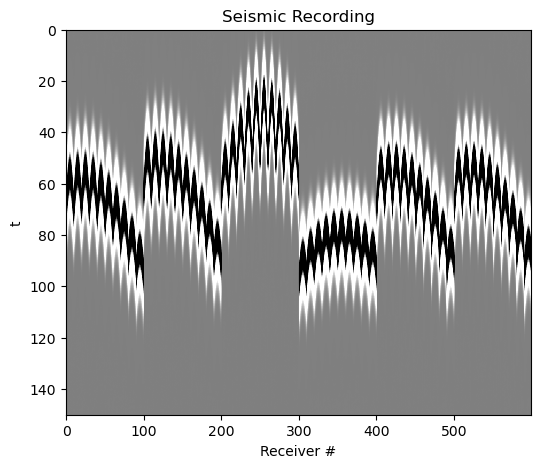

In [26]:
grid_data_1D = Op @ microseismic_line.ravel()
grid_data = grid_data_1D.reshape(nr,nt)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(grid_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.axis('tight')
ax.set_xlabel('Receiver #')
ax.set_ylabel('t')
ax.set_ylim([150,0])
ax.set_title('Seismic Recording')

In [10]:
# PERFORM ADJOINT (MIGRATE)
adj_1d = Op.H @ grid_data_1D
adj = adj_1d.reshape(nx,ny,nz)

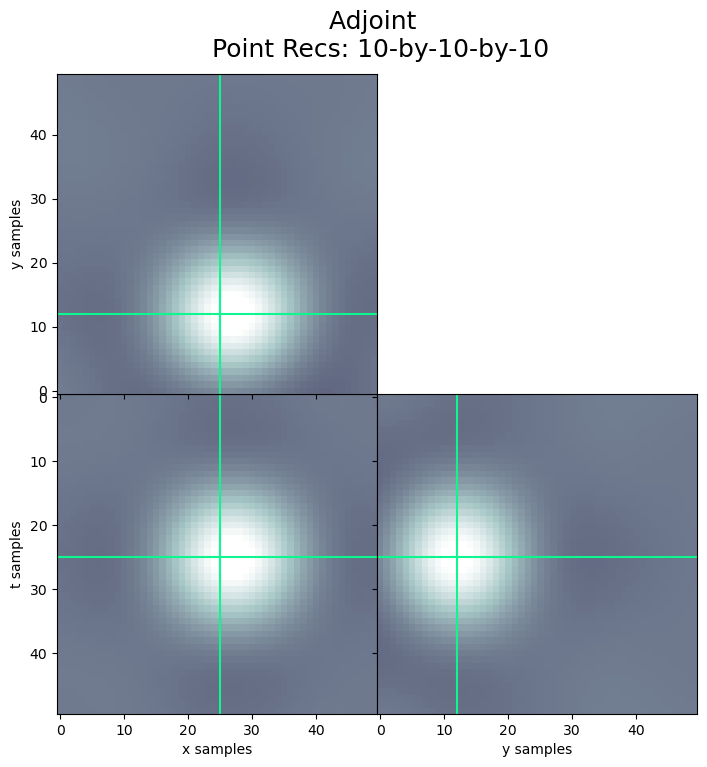

In [11]:
fig,axs = explode_volume(adj.transpose(2,0,1), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Adjoint \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()



 
LSQR            Least-squares solution of  Ax = b
The matrix A has 150600 rows and 125000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.495e+02  3.495e+02    1.0e+00  8.5e+00
     1 -3.04086e-05   1.664e+02  1.664e+02    4.8e-01  5.8e-01   3.4e+03  1.0e+00
     2 -6.73859e-05   1.058e+02  1.058e+02    3.0e-01  3.6e-01   4.4e+03  2.2e+00
     3 -5.75368e-05   8.009e+01  8.009e+01    2.3e-01  2.5e-01   5.1e+03  3.6e+00
     4 -6.32853e-06   6.603e+01  6.603e+01    1.9e-01  1.8e-01   5.8e+03  5.1e+00
     5  8.97397e-05   5.518e+01  5.518e+01    1.6e-01  1.9e-01   6.3e+03  7.0e+00
     6  1.88515e-04   4.601e+01  4.601e+01    1.3e-01  1.4e-01   6.9e+03  9.2e+00
     7  2.59761e-04   3.908e+01  3.908e+01    1.1e-01  1.2e-01   7.3e+03  1.1e+01
     8  2.77565e-04   3.564e+0

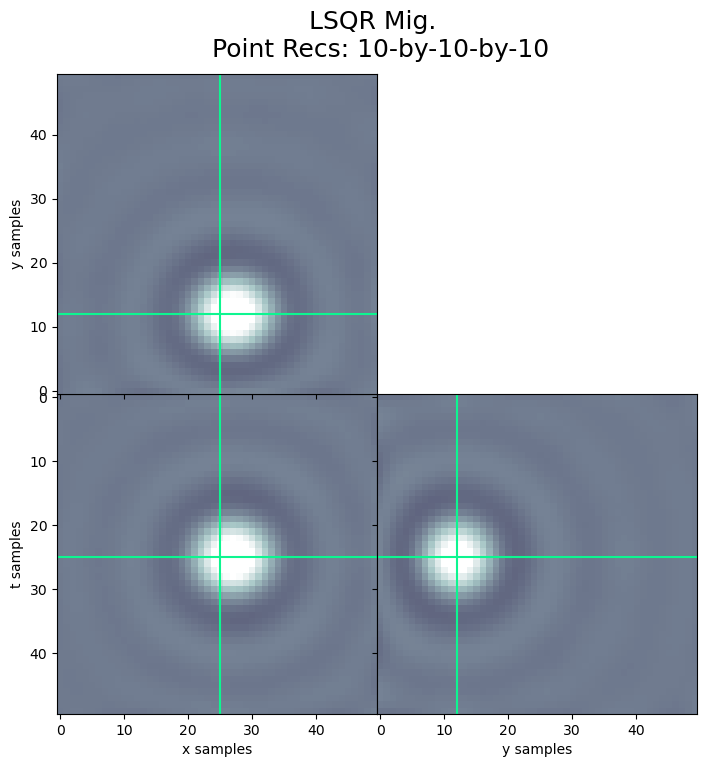

In [12]:
# PERFORM LSQR
minv_1d = lsqr(Op, grid_data_1D, iter_lim=100, show=True)[0]
minv = minv_1d.reshape(nx,ny,nz)

fig,axs = explode_volume(minv.transpose(2,0,1), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('LSQR Mig. \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 150600 rows and 125000 cols
eps = 1.000000e+01	tol = 1.000000e-10	niter = 100
alpha = 6.885865e-08	thresh = 3.442932e-07
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -2.3682e-05         1.592e+04   1.602e+04   7.163e-02
     2      -3.9342e-05         9.621e+03   9.734e+03   2.318e-02
     3      -4.8305e-05         6.241e+03   6.368e+03   1.907e-02
     4      -4.8284e-05         4.343e+03   4.483e+03   1.593e-02
     5      -3.8879e-05         3.226e+03   3.377e+03   1.347e-02
     6      -2.0944e-05         2.532e+03   2.691e+03   1.157e-02
     7       3.1921e-06         2.065e+03   2.232e+03   1.015e-02
     8       3.1689e-05         1.722e+03   1.894e+03   9.152e-03
     9       6.2478e-05         1.451e+03   1.628e+03   8.471e-03
    10      

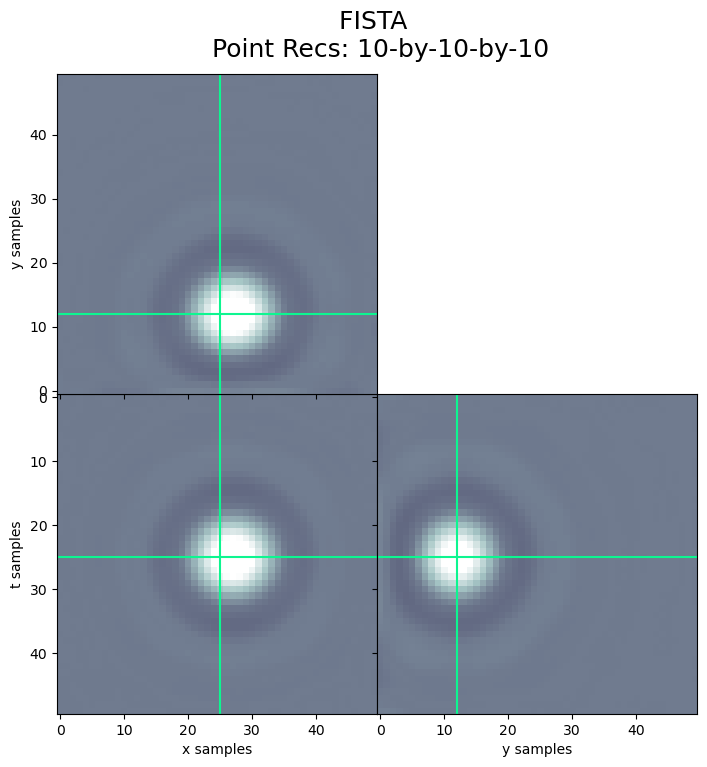

In [13]:
import pylops
epsilon = 1e1
with pylops.disabled_ndarray_multiplication():
    minv_sparse = fista(Op, grid_data_1D, 
                        niter=100, eps=epsilon, show=True)[0].reshape(nx,ny,nz)
    
fig,axs = explode_volume(minv_sparse.transpose(2,0,1), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('FISTA \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()

# SMART INVERSE

In [ ]:
n_faces = 6
faces_per_line = 4

# LINE A
RLA_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,2,3],
                      axis=0
                     )
SLA_Op = Sum((faces_per_line, nr_x, nr_x, nt), axis=2)

# LINE B
RLB_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[2,3,4,5],
                      axis=0
                     )
SLB_Op = Sum((faces_per_line, nr_x, nr_x, nt), axis=2)

# LINE C
RLC_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,4,5],
                      axis=0
                     )
SLC_Op = Sum((faces_per_line, nr_x, nr_x, nt), axis=2)

# COMBINING OPERATORS
Vop = VStack([SLA_Op.H @ SLA_Op @ RLA_Op, 
              SLB_Op.H @ SLB_Op @ RLB_Op,
              SLC_Op.H @ SLC_Op @ RLC_Op
             ])

LinesOp = Vop * Op

# check operator with dottest
_ = dottest(LinesOp, verb=True)

In [ ]:
# FORWARD MODEL DATA USING SUM AND SPREAD
pDAS_data = LinesOp @ microseismic_line.flatten()

In [ ]:
# PERFORM ADJOINT (MIGRATE)
pDAS_mig_1d = LinesOp.H @ pDAS_data
pDAS_mig = pDAS_mig_1d.reshape(nx,ny,nz)

fig,axs = explode_volume(pDAS_mig.transpose(2,0,1), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Adjoint \n Pseudo-DAS : %s'%rec_string, fontsize=18)
fig.tight_layout()


In [ ]:
# PERFORM LSQR
pDAS_minv = lsqr(LinesOp, pDAS_data.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)

fig,axs = explode_volume(pDAS_minv.transpose(2,0,1), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Inversion \n Pseudo-DAS : %s'%rec_string, fontsize=18)
fig.tight_layout()

In [ ]:
import pylops
epsilon = 1e2
with pylops.disabled_ndarray_multiplication():
    pDAS_minv_sparse = fista(LinesOp, pDAS_data.flatten(), 
                        niter=100, eps=epsilon, show=True)[0].reshape(nx,ny,nz)
    

fig,axs = explode_volume(pDAS_minv_sparse.transpose(2,0,1), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('FISTA \n Pseudo-DAS : %s'%rec_string, fontsize=18)
fig.tight_layout()